## MNIST 이미지에서 적절한 차원 수를 찾고 이미지를 압축해서 출력

In [8]:
# 데이터 가져오기
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape)

/Users/hyeongihong/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(52500, 784)


In [9]:
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +1
print(d)

154


In [10]:
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')


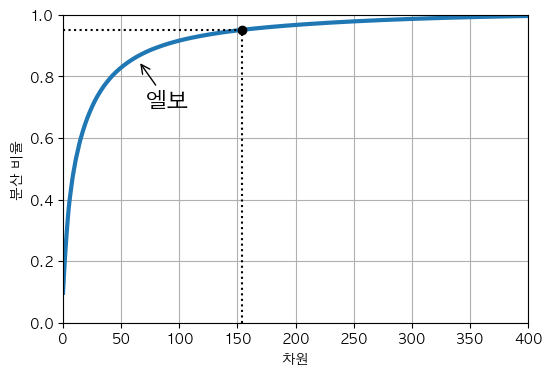

In [11]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("차원")
plt.ylabel("분산 비율")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("엘보", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [12]:
# 분ㅏㄴ 비율이 0.95 이상인 PCA 만들기
pca = PCA(n_components= 0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.n_components_)
print(pca.explained_variance_ratio_[:5])

154
[0.09725689 0.07178551 0.06137958 0.05416325 0.04861747]


In [13]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
print(X_recovered.shape) # 처음의 X_train.shape와 같음.

(52500, 784)


In [14]:
import matplotlib as mpl
def plot_digits(instances, images_per_row = 5, **options):
    size = 28

    # 한 줄에 출력할 이미지 개수 설정
    images_per_row = min(len(instances), images_per_row)

    # 1차원 이미지를 2차원으로 재구성
    images = [instance.reshape(size, size) for instance in instances]

    # 행의 개수 계산
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size * size * n_empty)))

    for row in range(n_rows):
        rimages = images[row * images_per_row : (row+1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)

    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

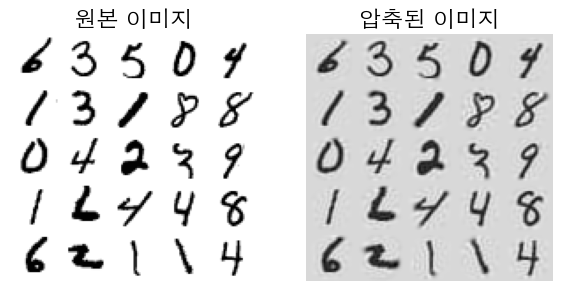

In [15]:
plt.figure(figsize = (7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title('원본 이미지', fontsize=16)

plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title('압축된 이미지', fontsize=16)

plt.show()

In [18]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154) 
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") 
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [20]:
filename = "./raw/train-images.idx3-ubyte"
m, n = X_train.shape
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train
print(m, n)


52500 784


In [23]:
del X_mm
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size) 
inc_pca.fit(X_mm)
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [24]:
import time


for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    # 주성분의 개수에 영향을 많이 받음
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    # 데이터를 나누어서 훈련하므로 많은 양의 데이터나 온라인 학습에 사용
    rnd_pca = PCA(n_components=n_components, random_state=42,
svd_solver="randomized")

for pca in (regular_pca, inc_pca, rnd_pca): 
    t1 = time.time()
    pca.fit(X_train)
    t2 = time.time()
    print(" {}: {:.1f} 초".format(pca.__class__.__name__, t2 - t1))

n_components = 2
n_components = 10
n_components = 154
 PCA: 5.2 초
 IncrementalPCA: 22.5 초
 PCA: 7.1 초


In [38]:
import time

for n_samples in [1000, 10000, 20000, 30000, 40000, 50000]:
    print('데이터의 개수', n_samples)
    X = np.random.randn(n_samples, 5)
    regular_pca = PCA(n_components=2, svd_solver="full")
    # 주성분의 개수에 영향을 많이 받음
    inc_pca = IncrementalPCA(n_components=2, batch_size=500)
    # 데이터를 나누어서 훈련하므로 많은 양의 데이터나 온라인 학습에 사용
    rnd_pca = PCA(n_components=2, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca): 
        t1 = time.time()
        pca.fit(X)
        t2 = time.time()
        print(" {}: {:.10f} 초".format(pca.__class__.__name__, t2 - t1))

데이터의 개수 1000
 PCA: 0.0016250610 초
 IncrementalPCA: 0.0014190674 초
 PCA: 0.0048367977 초
데이터의 개수 10000
 PCA: 0.0011870861 초
 IncrementalPCA: 0.0040581226 초
 PCA: 0.1778261662 초
데이터의 개수 20000
 PCA: 0.0331778526 초
 IncrementalPCA: 0.0114018917 초
 PCA: 0.3314518929 초
데이터의 개수 30000
 PCA: 0.0162911415 초
 IncrementalPCA: 0.0342772007 초
 PCA: 0.4217362404 초
데이터의 개수 40000
 PCA: 0.0186309814 초
 IncrementalPCA: 0.0460488796 초
 PCA: 0.4063990116 초
데이터의 개수 50000
 PCA: 0.0627000332 초
 IncrementalPCA: 0.0537168980 초
 PCA: 0.3659911156 초


In [39]:
import time

for n_features in [1000, 2000, 3000, 4000, 5000]:
    print('피처의 개수', n_features)

    X = np.random.randn(2000, 5)
    regular_pca = PCA(n_components=2, svd_solver="full")

    # 주성분의 개수에 영향을 많이 받음
    inc_pca = IncrementalPCA(n_components=2, batch_size=500)

    # 데이터를 나누어서 훈련하므로 많은 양의 데이터나 온라인 학습에 사용
    rnd_pca = PCA(n_components=2, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca): 
        t1 = time.time()
        pca.fit(X)
        t2 = time.time()
        print(" {}: {:.10f} 초".format(pca.__class__.__name__, t2 - t1))

피처의 개수 1000
 PCA: 0.0012683868 초
 IncrementalPCA: 0.0024640560 초
 PCA: 0.0339670181 초
피처의 개수 2000
 PCA: 0.0003559589 초
 IncrementalPCA: 0.0006690025 초
 PCA: 0.0011429787 초
피처의 개수 3000
 PCA: 0.0002408028 초
 IncrementalPCA: 0.0006239414 초
 PCA: 0.0012390614 초
피처의 개수 4000
 PCA: 0.0002319813 초
 IncrementalPCA: 0.0006067753 초
 PCA: 0.0181610584 초
피처의 개수 5000
 PCA: 0.0009310246 초
 IncrementalPCA: 0.0017778873 초
 PCA: 0.0243229866 초
